<a href="https://colab.research.google.com/github/simonetome/ApplieAI-Biomedicine-Masciulli-Pietrobon-Tome/blob/main/FinalResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install heartpy
!pip install PyWavelets

In [ ]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import tensorflow as tf 
from tensorflow import keras
import sys
from scipy.signal import resample, butter, lfilter, iirnotch
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import heartpy as hp
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import pywt as pw
SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [ ]:
#IF Colab cloud GPU used -> Mount the My Drive folder and set cwd
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/FinalAssignment'
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

Mounted at /content/drive


In [ ]:
#IF run locally
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)

In [ ]:
#IF local runtime used -> Set os.cwd as google drive volume , mounted locally
os.chdir('G:\Il mio Drive')
cwd = os.getcwd()
cwd = os.path.join(cwd,'Colab2022/AppliedAI/FinalAssignment')
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

In [ ]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
    label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
    peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
    signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
    if os.path.isfile(label_filepath):
        mat_file = loadmat(label_filepath)
        label = np.asarray(mat_file['labels'])
    if os.path.isfile(peak_filepath):
        mat_file = loadmat(peak_filepath)
        peaks = np.array(mat_file['rpeaks'],dtype=np.int64)
    if os.path.isfile(signal_filepath):
        mat_file = loadmat(signal_filepath)
        signal = np.asarray(mat_file['ecg'] )

    return label, peaks, signal


labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols

# transform peaks 
for id in tqdm(df.index.tolist()):
    peaks = df.iloc[id]['peaks']
    p_list = list()
    for p in peaks:
        p_list.append(p[0])
    df.iloc[id]['peaks'] = np.asarray(p_list).astype(np.int64)

df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1144.35it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S010,"[1.56, 0.92, 0.28, -0.36, -0.29, -0.2, -0.19, ...","[-5.12, -4.485, -3.85, -3.215, -2.58, -1.945, ...","[96, 169, 268, 360, 427, 539, 634, 714, 789, 8...",128,"[N, V, N, N, V, N, N, V, N, N, V, N, N, V, N, ..."
1,S009,"[0.27, 0.57, 0.36, -0.28, -0.39, -0.32, -0.37,...","[-0.43, -0.93, -1.48, -1.36, -0.82, -0.36, -0....","[105, 205, 262, 410, 510, 611, 667, 812, 917, ...",128,"[N, N, V, N, N, N, V, N, N, N, V, N, N, N, V, ..."
2,S008,"[0.405, 0.42, 0.415, 0.43, 0.415, 0.41, 0.445,...","[-0.32, -0.345, -0.325, -0.37, -0.385, -0.42, ...","[71, 153, 232, 280, 367, 419, 537, 632, 682, 8...",128,"[N, N, N, S, N, S, N, N, S, N, N, S, N, V, N, ..."
3,S007,"[0.145, 0.125, 0.145, 0.145, 0.145, 0.145, 0.1...","[-0.635, -0.745, -0.735, -0.695, -0.685, -0.68...","[49, 129, 216, 298, 380, 466, 550, 631, 719, 8...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S006,"[0.33, 0.31, 0.32, 0.28, 0.25, 0.22, 0.15, 0.1...","[0.27, 0.24, 0.23, 0.18, 0.16, 0.14, 0.09, 0.0...","[67, 170, 278, 386, 492, 602, 662, 811, 886, 1...",128,"[N, N, N, N, N, N, V, N, V, N, V, N, V, N, V, ..."


In [ ]:
# because of the curse of dimensionality --> undersampling 

from scipy.signal import resample

ids_128 = df[df['frequencies'] == 128].index.tolist() # 65 signals are sampled using fs = 128
ids_250 = df[df['frequencies'] == 250].index.tolist() # 65 signals are sampled using fs = 128
sampled_len =  len(df.iloc[ids_250[0]]['ecg_lead_1'])
resampled_len = len(df.iloc[ids_128[0]]['ecg_lead_1'])

for id in tqdm(ids_250):
    row = df.iloc[id]
    # first lead
    signal = np.asarray(row['ecg_lead_1']).astype(np.float32)
    resampled_1 = resample(signal,resampled_len)
    
    # second lead
    
    signal = np.asarray(row['ecg_lead_2']).astype(np.float32)
    resampled_2 = resample(signal,resampled_len)
    
    df.iloc[id]['ecg_lead_1'] = resampled_1.tolist()
    df.iloc[id]['ecg_lead_2'] = resampled_2.tolist()
    
    for i,p in enumerate(list(df.iloc[id]['peaks'])):
        df.iloc[id]['peaks'][i] = int(resampled_len * p/sampled_len)


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.46it/s]


<h2>Bandpass filtering

In [ ]:
#Preprocessing used in practical lessons
from scipy.signal import resample, butter, lfilter, iirnotch

def notch_filter(cutoff, fs, q=30):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a


def bandpass_filter(data, filter_order=6, lowcut = .8, highcut = 45, signal_freq=128):
    """
    Method responsible for creating and applying Butterworth filter.
    :param deque data: raw data
    :param float lowcut: filter lowcut frequency value
    :param float highcut: filter highcut frequency value
    :param int signal_freq: signal frequency in samples per second (Hz)
    :param int filter_order: filter order
    :return array: filtered data
    """
    powerline = 60
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype="band")
    y = lfilter(b, a, data,zi = None)
    #b,a = notch_filter(powerline,signal_freq)
    #y = lfilter(b,a,y)
    return y



filtered_df = df.copy(deep= True)

ids = filtered_df.index.tolist()

for id_ in tqdm(ids):
    
    row = filtered_df.iloc[id_]
    first = row['ecg_lead_1']
    second = row['ecg_lead_2']
    filtered_first = np.asarray(bandpass_filter(first))
    filtered_second =  np.asarray(bandpass_filter(second))

    filtered_df.iloc[id_]['ecg_lead_1'] = pd.Series(filtered_first)
    filtered_df.iloc[id_]['ecg_lead_2'] = pd.Series(filtered_second)

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:02<00:00, 52.11it/s]


['N', 'N', 'N']


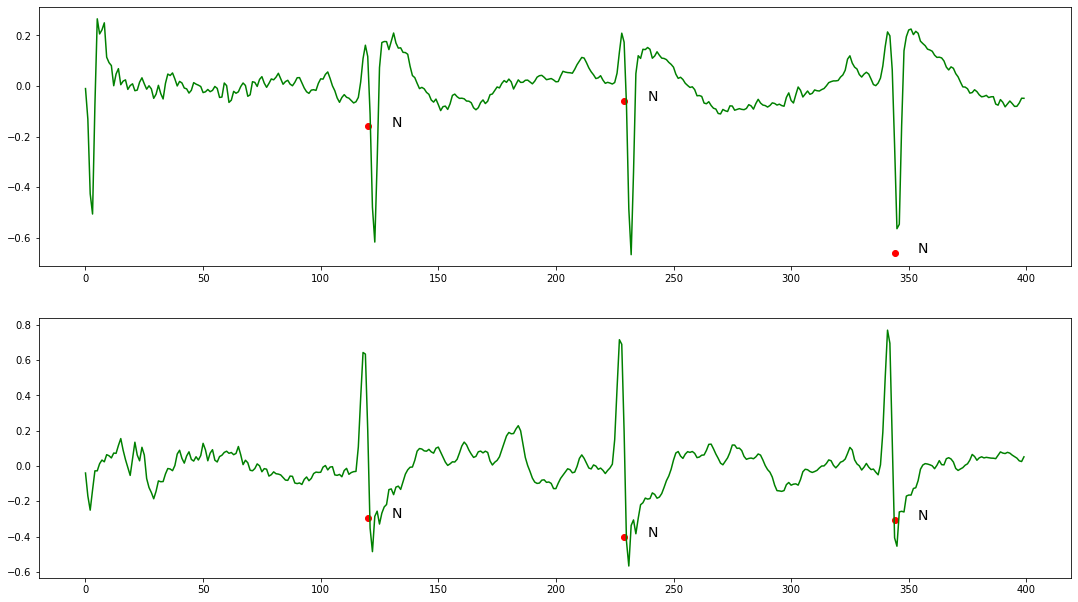

['N', 'N', 'N']


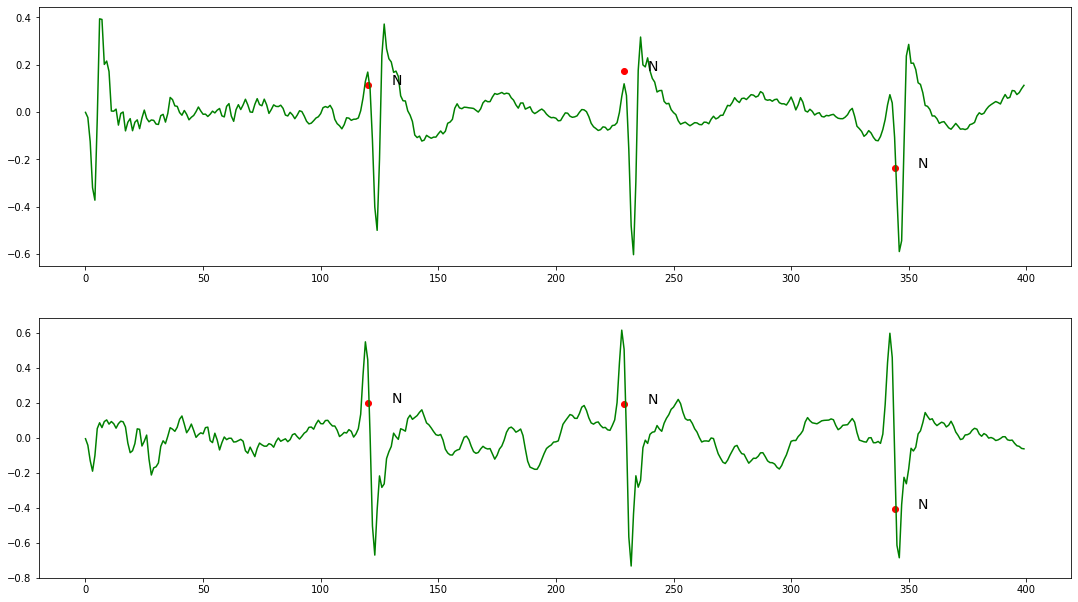

In [ ]:
# plot signal 
from scipy.fft import fft, fftfreq

def plot_signal(df,id,length):
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
    
    
    signal = df.iloc[id]
    
    first_lead = signal['ecg_lead_1'][:length]
    second_lead = signal['ecg_lead_2'][:length]
    
    peaks_ = signal['peaks']
    labels_ = signal['labels']
    
    x = list(range(length))
    
    #ax1.plot(x,first_lead,color='blue')
    #ax2.plot(x,second_lead,color='blue')
    
    ax1.plot(x,bandpass_filter(first_lead),color='green')
    ax2.plot(x,bandpass_filter(second_lead),color='green')


    
    peaks = list()
    p_amplitudes_first = list()
    p_amplitudes_second = list()
    labels = list()
    
    for i,p in enumerate(peaks_):
        if(p <= length):
            peaks.append(p)
            p_amplitudes_first.append(first_lead[p])
            p_amplitudes_second.append(second_lead[p])
            labels.append(labels_[i])
        else:
            break
            
    ax1.scatter(peaks,p_amplitudes_first,color='red')
    ax2.scatter(peaks,p_amplitudes_second,color='red')
    offset = 10
    
    for i, txt in enumerate(labels):
        ax1.annotate(txt, (peaks[i]+offset, p_amplitudes_first[i]),size = 14)
        ax2.annotate(txt, (peaks[i]+offset, p_amplitudes_second[i]),size = 14)
    
    print(labels)
    plt.show()

plot_signal(df,50,400)
plot_signal(filtered_df,50,400)

<h2>Scaling to [0:1] in 10 seconds time window 

In [ ]:
import heartpy as hp

fs = 128
time_window = 10
samples = fs * time_window ##

for id in tqdm(filtered_df.index.tolist()):
    row = filtered_df.loc[id]
    first_lead = row['ecg_lead_1']
    second_lead = row['ecg_lead_2']
    l_ = len(first_lead)
    scaled_1 = list()
    scaled_2 = list()
#    
    for i in range(int(l_/samples)):
        to_scale_1 = first_lead[i*samples:i*samples+samples] 
        to_scale_2 = second_lead[i*samples:i*samples+samples]
#        
        scaled_1 += list(hp.scale_data(to_scale_1,lower=0,upper=1))
        scaled_2 += list(hp.scale_data(to_scale_2,lower=0,upper=1))
 ##   
    filtered_df.loc[id]['ecg_lead_1'] = scaled_1
    filtered_df.loc[id]['ecg_lead_2'] = scaled_2

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:19<00:00,  5.26it/s]


<h2>Outliers detection and removal using zscore</h2>

In [ ]:
from scipy import stats

# Function for the computation of rhythm data 
def get_2ECG_rhythmfeatures(data):
  
  #   mean
  mean_lead = np.mean(data)

  #   median
  median_lead = np.median(data)

  #   standard deviation
  std_lead = np.std(data)

  #   variance
  var_lead = stats.tvar(data)

  #   Skewness
  skew_lead = stats.skew(data)

  #   Kurtosis
  kurt_lead = stats.kurtosis(data)

  features = np.hstack([mean_lead,median_lead,std_lead,var_lead,skew_lead,kurt_lead])

  return features
#-------------------------------------------------------------------------------

#Training

features_rhythm_lead1 = list()
features_rhythm_lead2 = list()


for i in range(filtered_df.shape[0]):
  tmp_lead1 = get_2ECG_rhythmfeatures(filtered_df['ecg_lead_1'][i])
  features_rhythm_lead1.append(tmp_lead1)
  tmp_lead2 = get_2ECG_rhythmfeatures(filtered_df['ecg_lead_2'][i])
  features_rhythm_lead2.append(tmp_lead2)

features_rhythm_lead1 = pd.DataFrame(features_rhythm_lead1, columns = ['mean_lead1', 'median_lead1', 'std_lead1', 'var_lead1', 'skew_lead1','kurt_lead1'])
features_rhythm_lead2 = pd.DataFrame(features_rhythm_lead2, columns = ['mean_lead2', 'median_lead2', 'std_lead2', 'var_lead2', 'skew_lead2','kurt_lead2'])

features_rhythm = pd.concat([features_rhythm_lead1, features_rhythm_lead2], axis=1)

features = pd.DataFrame(features_rhythm, columns = ['mean_lead1', 'median_lead1', 'std_lead1', 'var_lead1', 'skew_lead1','kurt_lead1',
                                                    'mean_lead2', 'median_lead2', 'std_lead2', 'var_lead2', 'skew_lead2','kurt_lead2'])
display(features) 

,mean_lead1,median_lead1,std_lead1,var_lead1,skew_lead1,kurt_lead1,mean_lead2,median_lead2,std_lead2,var_lead2,skew_lead2,kurt_lead2
0,0.518545,0.519861,0.128440,0.016497,0.059733,2.411543,0.516446,0.508935,0.158898,0.025249,0.108288,0.750694
1,0.514060,0.526888,0.151582,0.022977,-0.617166,2.148906,0.562998,0.554163,0.144557,0.020897,0.042675,2.028877
2,0.484899,0.468542,0.167638,0.028103,0.459591,1.565434,0.439204,0.438163,0.124409,0.015478,0.397845,4.025946
3,0.648238,0.650607,0.114506,0.013112,-1.089590,5.253119,0.606299,0.597995,0.125922,0.015856,-0.527416,3.978899
4,0.583688,0.591003,0.136579,0.018654,-0.678921,2.895805,0.579683,0.580753,0.143641,0.020633,-0.158144,1.475109
...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.673085,0.676576,0.116990,0.013687,-2.135296,9.444959,0.557697,0.556771,0.131509,0.017295,-0.343554,2.319663
101,0.433995,0.451614,0.128814,0.016593,0.291470,4.808244,0.506547,0.523356,0.133414,0.017799,-0.479382,2.615935
102,0.292959,0.291048,0.119797,0.014351,2.748148,13.167939,0.324978,0.324025,0.116158,0.013493,2.657186,13.140050
103,0.581960,0.593739,0.178191,0.031752,-0.633201,0.226767,0.334881,0.331823,0.126061,0.015891,1.313724,6.389842


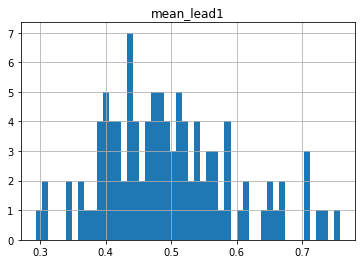

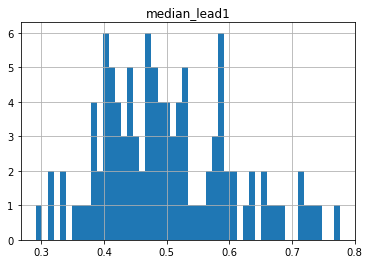

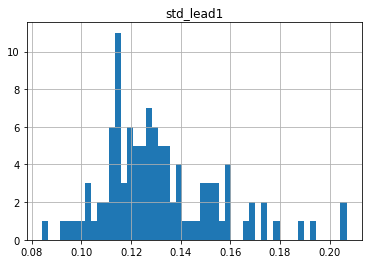

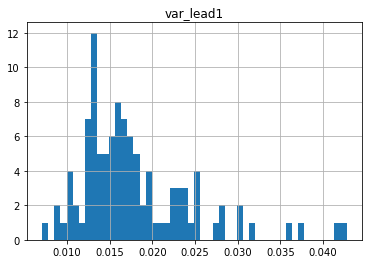

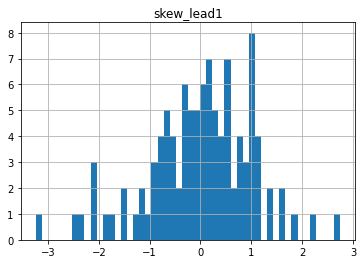

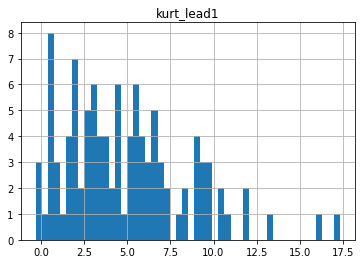

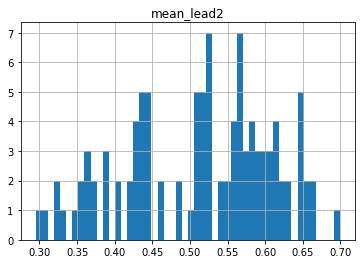

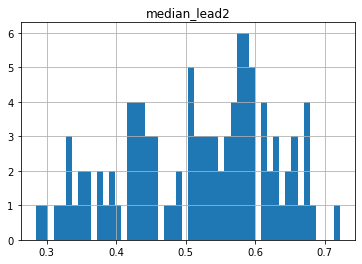

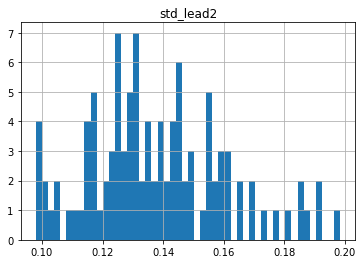

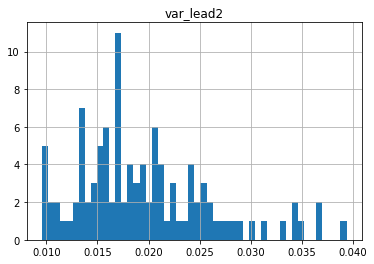

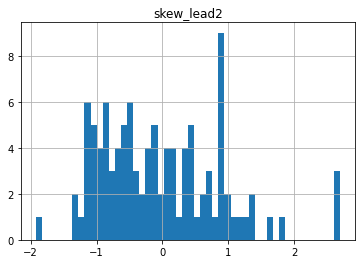

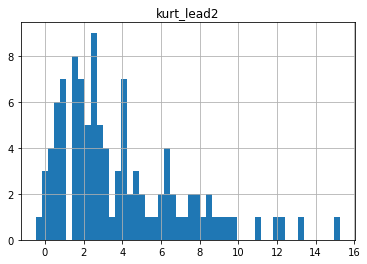

In [ ]:
# Visualize data distribution for each feature
for col in features.columns: 
      features.hist(column = col, bins = 50)

In [ ]:
def plot_outliersAnalysis(abs_zscores):
  # number of outliers per subject 
  bool_zscores = (abs_zscores > 3).sum(axis=1)
  bool_zscores.hist()
  plt.title("Number of outliers per subject")
  plt.show()

  # number of outliers per feature 
  bool_zscores = (abs_zscores > 3).sum(axis=0)
  #bool_zscores.hist(bins = len(feature_list))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])

  ax.bar(feature_list,bool_zscores)
  plt.title("Number of outliers per feature")
  plt.xticks(np.arange(len(feature_list)), feature_list,rotation=90)
  plt.show()
  return

Train subjects before outlier removal: (105, 12)
Train subjects after outlier removal: (99, 12)


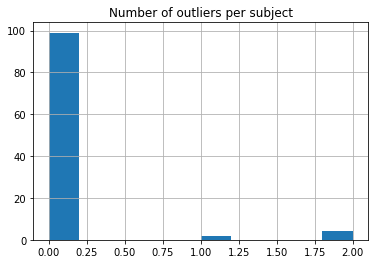

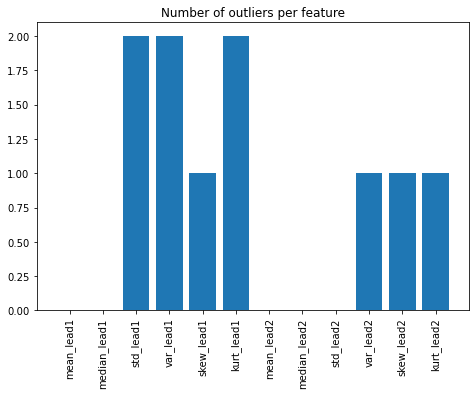

,mean_lead1,median_lead1,std_lead1,var_lead1,skew_lead1,kurt_lead1,mean_lead2,median_lead2,std_lead2,var_lead2,skew_lead2,kurt_lead2
0,0.518545,0.519861,0.128440,0.016497,0.059733,2.411543,0.516446,0.508935,0.158898,0.025249,0.108288,0.750694
1,0.514060,0.526888,0.151582,0.022977,-0.617166,2.148906,0.562998,0.554163,0.144557,0.020897,0.042675,2.028877
2,0.484899,0.468542,0.167638,0.028103,0.459591,1.565434,0.439204,0.438163,0.124409,0.015478,0.397845,4.025946
3,0.648238,0.650607,0.114506,0.013112,-1.089590,5.253119,0.606299,0.597995,0.125922,0.015856,-0.527416,3.978899
4,0.583688,0.591003,0.136579,0.018654,-0.678921,2.895805,0.579683,0.580753,0.143641,0.020633,-0.158144,1.475109
...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.673085,0.676576,0.116990,0.013687,-2.135296,9.444959,0.557697,0.556771,0.131509,0.017295,-0.343554,2.319663
101,0.433995,0.451614,0.128814,0.016593,0.291470,4.808244,0.506547,0.523356,0.133414,0.017799,-0.479382,2.615935
102,0.292959,0.291048,0.119797,0.014351,2.748148,13.167939,0.324978,0.324025,0.116158,0.013493,2.657186,13.140050
103,0.581960,0.593739,0.178191,0.031752,-0.633201,0.226767,0.334881,0.331823,0.126061,0.015891,1.313724,6.389842


In [ ]:
# Perform z-scoring for outlier removal
from scipy.stats import zscore
import numpy as np

feature_list = features.columns.tolist()
print('Train subjects before outlier removal: ' + str(features.shape))

# apply zscore
zscore_features = features.apply(zscore, axis=0)

# select all those values with zscore < -+ 3 and discard outliers 
abs_zscores = np.abs(zscore_features)
filtered_entries = (abs_zscores < 3).all(axis=1)

features_or = features[filtered_entries]

print('Train subjects after outlier removal: ' + str(features_or.shape))


plot_outliersAnalysis(abs_zscores)
display(features_or)

In [ ]:
#Discard outliers
filtered_df = filtered_df.loc[features_or.index]
filtered_df

,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S010,"[0.6096413762096455, 0.7881107045443922, 0.841...","[0.625976302567932, 0.24770117339168152, 0.0, ...","[96, 169, 268, 360, 427, 539, 634, 714, 789, 8...",128,"[N, V, N, N, V, N, N, V, N, N, V, N, N, V, N, ..."
1,S009,"[0.5170343975577097, 0.5991472535018061, 0.703...","[0.5352054040200634, 0.4229244819994284, 0.227...","[105, 205, 262, 410, 510, 611, 667, 812, 917, ...",128,"[N, N, V, N, N, N, V, N, N, N, V, N, N, N, V, ..."
2,S008,"[0.5284620003350411, 0.5791841228324992, 0.620...","[0.3983029391088456, 0.3514248516552202, 0.312...","[71, 153, 232, 280, 367, 419, 537, 632, 682, 8...",128,"[N, N, N, S, N, S, N, N, S, N, N, S, N, V, N, ..."
3,S007,"[0.6902598069259476, 0.7850522714106655, 0.853...","[0.4982137562964564, 0.2769731276143207, 0.074...","[49, 129, 216, 298, 380, 466, 550, 631, 719, 8...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S006,"[0.6062245640616534, 0.6458434735262665, 0.675...","[0.5644771460312897, 0.6151896110134574, 0.650...","[67, 170, 278, 386, 492, 602, 662, 811, 886, 1...",128,"[N, N, N, N, N, N, V, N, V, N, V, N, V, N, V, ..."
...,...,...,...,...,...,...
100,S110,"[0.6581314995127282, 0.6665311488655177, 0.669...","[0.5775497416495486, 0.6137709378111199, 0.620...","[57, 132, 242, 314, 406, 492, 592, 685, 781, 9...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
101,S107,"[0.46498188873494767, 0.4941683096869004, 0.53...","[0.6606664811325684, 0.7252491222177425, 0.803...","[107, 229, 348, 467, 586, 702, 820, 936, 1052,...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
102,S108,"[0.301868312565112, 0.31540587102458645, 0.337...","[0.3319843446612265, 0.3449634441504563, 0.366...","[181, 278, 378, 478, 578, 679, 781, 882, 983, ...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
103,S109,"[0.6127951792794833, 0.7437216882289416, 0.814...","[0.3589683074700886, 0.3482897116641143, 0.329...","[28, 137, 254, 373, 493, 615, 738, 858, 977, 1...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


<h2> RR distances analysis

In [ ]:
signal_ids = filtered_df.index.tolist()
RR_dict = {}

for id_ in tqdm(signal_ids):  
  sig_Id = df.iloc[id_]['sigId']
  RR_dict[sig_Id] = {}
  RR_dict[sig_Id]['RR_distances'] = list()
  RR_dict[sig_Id]['S_distances'] = list()
  
  peaks = df.iloc[id_]['peaks']
  labels = df.iloc[id_]['labels']

  for i,p in enumerate(peaks[1:-1]):
    RR_distance = p-peaks[i]
    if(RR_distance < 250): # discard outliers
      RR_dict[sig_Id]['RR_distances'].append(RR_distance)
      if(labels[i+1] == 'S'):
        RR_dict[sig_Id]['S_distances'].append(RR_distance)

  RR_dict[sig_Id]['RR_distances'] = np.asarray(RR_dict[sig_Id]['RR_distances'])
  RR_dict[sig_Id]['S_distances'] = np.asarray(RR_dict[sig_Id]['S_distances'])

  RR_dict[sig_Id]['Avg_RR_distance'] = RR_dict[sig_Id]['RR_distances'].mean()
  RR_dict[sig_Id]['AVG_S_distance'] = RR_dict[sig_Id]['S_distances'].mean()


RR_df = pd.DataFrame.from_dict(RR_dict,orient="index")
RR_df.tail()

  0%|                                                                                           | 0/99 [00:00<?, ?it/s]<ipython-input-14-4695b0eb9ee0>:24: RuntimeWarning: Mean of empty slice.
  RR_dict[sig_Id]['AVG_S_distance'] = RR_dict[sig_Id]['S_distances'].mean()
100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 386.24it/s]


,RR_distances,S_distances,Avg_RR_distance,AVG_S_distance
S110,"[75, 110, 72, 92, 86, 100, 93, 96, 133, 94, 98...",[],94.759984,NaN
S107,"[122, 119, 119, 119, 116, 118, 116, 116, 114, ...",[86],111.120715,86.0
S108,"[97, 100, 100, 100, 101, 102, 101, 101, 101, 1...",[64],94.134615,64.0
S109,"[109, 117, 119, 120, 122, 123, 120, 119, 117, ...",[],124.099730,NaN
S106,"[85, 86, 84, 84, 84, 84, 85, 83, 84, 82, 85, 8...",[],88.333333,NaN


In [ ]:
import heartpy as hp 

classes = np.array(["N","S","V"])

patch_length = 350 

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_dataset(df):
    
    dataset_dict = {}
    ids = df['sigId']
   
    for id in tqdm(ids):
        row = df[df['sigId'] == id]
        sigId = row['sigId'].values[0]
        peaks = row['peaks'].values[0]
        first_lead_signal = row['ecg_lead_1'].values[0]
        second_lead_signal = row['ecg_lead_2'].values[0]
        labels = row['labels'].values[0]
        avg_RR = RR_df.loc[sigId]['Avg_RR_distance'] # T for the signal 

        for i,peak in enumerate(peaks):
            
            stringIdx = str(sigId)+'_'+str(i)    
            dataset_dict[stringIdx] = {}
            dataset_dict[stringIdx]["first_lead"] = list()
            dataset_dict[stringIdx]["second_lead"] = list()
            size = list(range(int(peak-(avg_RR)),int(peak+avg_RR)))

            for s in size:
                if(s < 0 or s >= len(first_lead_signal)):
                    dataset_dict[stringIdx]["first_lead"].append(0.5)
                    dataset_dict[stringIdx]["second_lead"].append(0.5)
                else:
                    dataset_dict[stringIdx]["first_lead"].append(first_lead_signal[s])
                    dataset_dict[stringIdx]["second_lead"].append(second_lead_signal[s])
            
            first_lead = dataset_dict[stringIdx]["first_lead"][:]
            second_lead = dataset_dict[stringIdx]["second_lead"][:]
            
            first_lead = resample(first_lead,patch_length)
            second_lead = resample(second_lead,patch_length)
            
            dataset_dict[stringIdx]["first_lead"] = first_lead[:]
            dataset_dict[stringIdx]["second_lead"] = second_lead[:]
            
            #dataset_dict[stringIdx]["dwt_1"] = pywt.dwt(first_lead,'db4','constant')
            #dataset_dict[stringIdx]["dwt_2"] = pywt.dwt(second_lead,'db4','constant')

            #dataset_dict[stringIdx]["dwt_1"] = pywt.wavedec(first_lead, 'db3', level=2)
            #dataset_dict[stringIdx]["dwt_2"] = pywt.wavedec(second_lead, 'db3', level=2)
            
            dataset_dict[stringIdx]["stringLabel"] = labels[i]
            dataset_dict[stringIdx]["label"] = convert_to_one_hot(labels[i])

    dataset_df = pd.DataFrame.from_dict(dataset_dict,orient="index")
    return dataset_df

<h2> Split dataset by patient & creation of patches

In [ ]:
validation_percentage = 0.2
training_df, validation_df = train_test_split(filtered_df,test_size = validation_percentage,random_state=SEED)

training_patches_df_ = create_patch_dataset(training_df)
validation_patches_df_ = create_patch_dataset(validation_df)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.47it/s]


In [ ]:
validation_patches_df_[(validation_patches_df_['stringLabel']=='S')]

,first_lead,second_lead,stringLabel,label
S098_375,"[0.6567262747324103, 0.654832831741922, 0.6408...","[0.637181017599411, 0.6365824396061848, 0.6696...",S,"[0.0, 1.0, 0.0]"
S098_385,"[0.5384843466677223, 0.5348115557205031, 0.538...","[0.35782209411772503, 0.327437310897747, 0.387...",S,"[0.0, 1.0, 0.0]"
S098_389,"[0.5035473082218382, 0.5315863367955641, 0.488...","[0.27976071666882846, 0.2901583722432402, 0.36...",S,"[0.0, 1.0, 0.0]"
S098_511,"[0.6591384693382958, 0.6383969096327072, 0.674...","[0.6005113396086094, 0.6213454235949077, 0.596...",S,"[0.0, 1.0, 0.0]"
S098_1026,"[0.40513352026026206, 0.4035369703789593, 0.52...","[0.4579503362291573, 0.3839446846839896, 0.448...",S,"[0.0, 1.0, 0.0]"
...,...,...,...,...
S027_2911,"[0.5112282376812893, 0.4993505715891076, 0.510...","[0.6243844591982252, 0.6443661546315003, 0.640...",S,"[0.0, 1.0, 0.0]"
S027_2912,"[0.5756517831076687, 0.5729708470002758, 0.572...","[0.5873022744502688, 0.589596866201821, 0.5631...",S,"[0.0, 1.0, 0.0]"
S027_2917,"[0.6031961456871199, 0.6070881280367812, 0.601...","[0.5519693761008746, 0.5733258231030034, 0.563...",S,"[0.0, 1.0, 0.0]"
S027_2993,"[0.5104034291364508, 0.5014134980146143, 0.516...","[0.56382084548168, 0.5871726950040405, 0.59054...",S,"[0.0, 1.0, 0.0]"


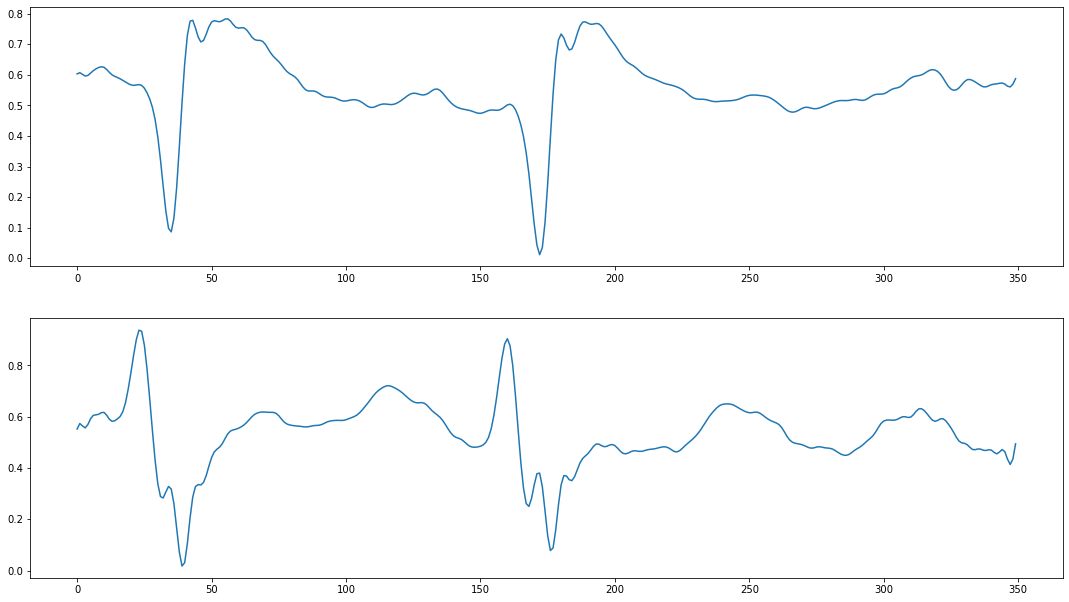

In [ ]:
    signal = validation_patches_df_.loc["S027_2917"]
    length = len(signal['first_lead'])
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
  
    
    first_lead = signal['first_lead'][:length]
    second_lead = signal['second_lead'][:length]
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    plt.show()

In [ ]:
validation_patches_df_[(validation_patches_df_['stringLabel']=='V')]

,first_lead,second_lead,stringLabel,label
S111_2110,"[0.535573313320724, 0.5703419976551095, 0.5344...","[0.4444654423438538, 0.3826950218054279, 0.453...",V,"[0.0, 0.0, 1.0]"
S092_642,"[0.3447725799154583, 0.3137617259396077, 0.333...","[0.41527907109763784, 0.4059350882054256, 0.42...",V,"[0.0, 0.0, 1.0]"
S092_644,"[0.5869127208197601, 0.6065023177557994, 0.557...","[0.5351342763892157, 0.5486919098895037, 0.526...",V,"[0.0, 0.0, 1.0]"
S034_12,"[0.5878329694542751, 0.5530628903481579, 0.592...","[0.32087955411195285, 0.30423058051417456, 0.3...",V,"[0.0, 0.0, 1.0]"
S034_30,"[0.5507577607922185, 0.523600159498513, 0.5574...","[0.3305916749275821, 0.33995093799561693, 0.34...",V,"[0.0, 0.0, 1.0]"
...,...,...,...,...
S027_2982,"[0.485368273542304, 0.47351688542253034, 0.469...","[0.6497896589698609, 0.657641706614446, 0.6325...",V,"[0.0, 0.0, 1.0]"
S027_2988,"[0.6298705082819533, 0.6771036713470499, 0.627...","[0.539966384975968, 0.5339734909509634, 0.5245...",V,"[0.0, 0.0, 1.0]"
S027_2989,"[0.4421839946802344, 0.44053093448651376, 0.45...","[0.4514247448601862, 0.4554605236679688, 0.446...",V,"[0.0, 0.0, 1.0]"
S027_2991,"[0.5841177169567502, 0.5946564736972841, 0.574...","[0.5315573130202756, 0.5351420061322011, 0.520...",V,"[0.0, 0.0, 1.0]"


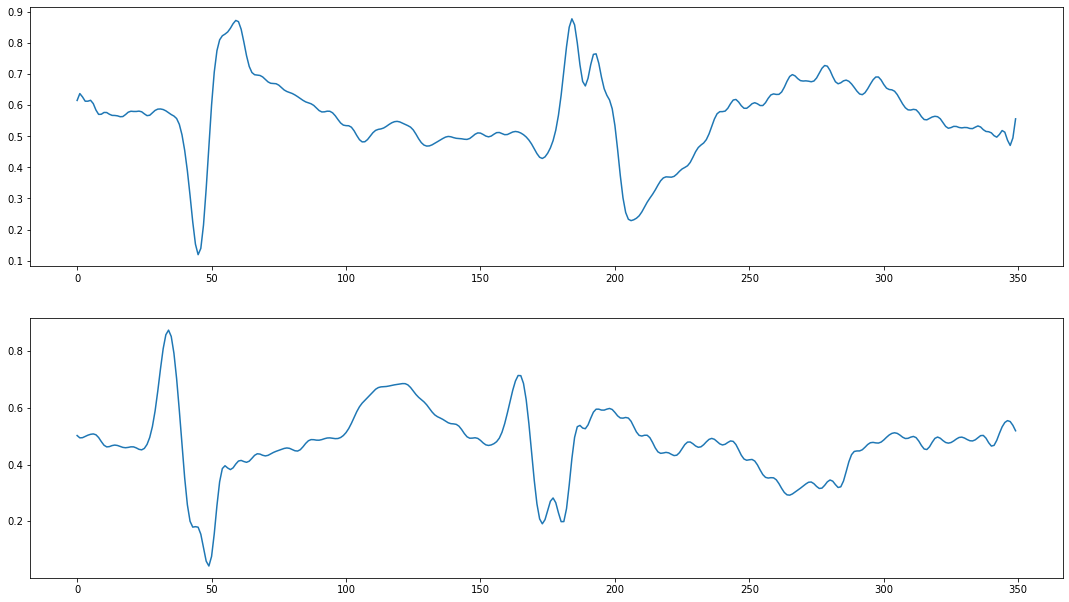

In [ ]:
    signal = validation_patches_df_.loc["S027_2997"]
    length = len(signal['first_lead'])
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
  
    
    first_lead = signal['first_lead'][:length]
    second_lead = signal['second_lead'][:length]
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    plt.show()

<h2> Drop and resampling 

How many training indx: 168919
Balancing training...
pre drop: 181459
post drop:25956
44176
2437
1766
Balancing validation


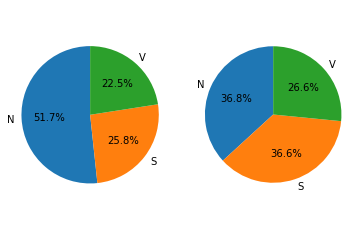

In [ ]:
training_patches_df = training_patches_df_.copy(deep=True)
validation_patches_df = validation_patches_df_.copy(deep=True)

training_df.head()

training_patients = training_df['sigId']
validation_patients = validation_df['sigId']

# calculate percentage of heartbeats to drop 

num_n = len(training_patches_df[(training_patches_df['stringLabel']=='N')])
num_s = len(training_patches_df[(training_patches_df['stringLabel']=='S')])
num_v = len(training_patches_df[(training_patches_df['stringLabel']=='V')])
to_drop = num_n - max(num_s,num_v) * 2
perc_to_drop_train = to_drop/(num_n)

num_n = len(validation_patches_df[(validation_patches_df['stringLabel']=='N')])
num_s = len(validation_patches_df[(validation_patches_df['stringLabel']=='S')])
num_v = len(validation_patches_df[(validation_patches_df['stringLabel']=='V')])
to_drop = num_n - max(num_s,num_v)
perc_to_drop_valid = to_drop/(num_n)

train_indexes = training_patches_df.index[training_patches_df['stringLabel'] == 'N'].tolist()
valid_indexes = validation_patches_df.index[validation_patches_df['stringLabel'] == 'N'].tolist()

print(f"How many training indx: {len(train_indexes)}")

train_to_drop = list()
valid_to_drop = list()
lengths = list()
dict_train = {}
valid_train = {}

print("Balancing training...")

for p in training_patients:
    dict_train[p] = list()

for hb in train_indexes:
    dict_train[hb.split('_')[0]].append(hb)

for p in dict_train:
   random.shuffle(dict_train[p])

for k in dict_train:
    train_to_drop += dict_train[k][:int(len(dict_train[k]) * perc_to_drop_train)]

print(f"pre drop: {len(training_patches_df.index)}")
training_patches_df = training_patches_df.drop(train_to_drop)
print(f"post drop:{len(training_patches_df.index)}")
print(num_n)
print(num_s)
print(num_v)
print("Balancing validation")

for p in validation_patients:
    valid_train[p] = list()
    
for hb in valid_indexes:
    valid_train[hb.split('_')[0]].append(hb)

for p in valid_train:
    random.shuffle(valid_train[p])

for k in valid_train:
    valid_to_drop += valid_train[k][:int(perc_to_drop_valid * len(valid_train[k]))]

validation_balanced_patches_df = validation_patches_df.drop(valid_to_drop)


training_labels = training_patches_df['stringLabel'].values
validation_labels = validation_balanced_patches_df['stringLabel'].values

classes = ["N","S","V"]

training_counts = [0]*3
validation_counts = [0]*3

for l in training_labels:
    training_counts[classes.index(l)] += 1
for l in validation_labels:
    validation_counts[classes.index(l)] += 1

fig1, (ax1,ax2) = plt.subplots(1,2)

ax1.pie(training_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  
ax2.pie(validation_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2.axis('equal')  

fig1.set_facecolor("white")

plt.show()


In [ ]:
# resample v and s
from sklearn.utils import shuffle


ids_S = training_patches_df.index[training_patches_df['stringLabel']=='S']
ids_V = training_patches_df.index[training_patches_df['stringLabel']=='V']
ids_N = training_patches_df.index[training_patches_df['stringLabel']=='N']

to_add = {}

to_resample_s = len(ids_N) - len(ids_S)
to_resample_v = len(ids_N) - len(ids_V)

for i in tqdm(range(to_resample_s)):
    id = random.choice(ids_S)
    row = training_patches_df.loc[id]
    idx = id + '_' + str(i)
    to_add[idx] = {}
    to_add[idx]['first_lead'] = row['first_lead']
    to_add[idx]['second_lead'] = row['second_lead']
    to_add[idx]['stringLabel'] = row['stringLabel']
    to_add[idx]['label'] = row['label']



for i in tqdm(range(to_resample_v)):
    id = random.choice(ids_V)
    row = training_patches_df.loc[id]
    idx = id + '_i'
    to_add[idx] = {}
    to_add[idx]['first_lead'] = row['first_lead']
    to_add[idx]['second_lead'] = row['second_lead']
    to_add[idx]['stringLabel'] = row['stringLabel']
    to_add[idx]['label'] = row['label']


to_add_df = pd.DataFrame.from_dict(to_add,orient="index")
training_patches_df = pd.concat([training_patches_df,to_add_df],axis=0) 
training_patches_df = shuffle(training_patches_df)


100%|███████████████████████████████████████████████████████████████████████████| 7563/7563 [00:00<00:00, 15799.25it/s]


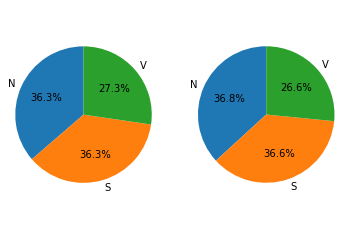

In [ ]:

training_labels = training_patches_df['stringLabel'].values
validation_labels = validation_balanced_patches_df['stringLabel'].values

classes = ["N","S","V"]

training_counts = [0]*3
validation_counts = [0]*3

for l in training_labels:
    training_counts[classes.index(l)] += 1
for l in validation_labels:
    validation_counts[classes.index(l)] += 1

fig1, (ax1,ax2) = plt.subplots(1,2)

ax1.pie(training_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  
ax2.pie(validation_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2.axis('equal')  

fig1.set_facecolor("white")

plt.show()

<h2>Create input

In [ ]:
def create_input(df):
    
    x = list()
    y = list()
    
    for id in tqdm(df.index.tolist()):
        row = df.loc[id]
        x.append(np.transpose(np.asarray([row['first_lead'],row['second_lead']]).astype(np.float32)))
        y.append(row['label'])

    x = np.asarray(x).astype(np.float32)
    y = np.asarray(y).astype(np.float32)
    
    return x,y


In [ ]:
x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_balanced_patches_df)
x_test,y_test = create_input(validation_patches_df)

100%|███████████████████████████████████████████████████████████████████████████| 6651/6651 [00:00<00:00, 10714.90it/s]


In [ ]:
#metric to monitor lr 
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

pos freqs: [0.36343935 0.36343935 0.2731213 ]
neg freqs: [0.6365607 0.6365607 0.7268787]
Epoch 1/100
1153/1153 [==============================] - 37s 30ms/step - loss: 0.3987 - precision: 0.8688 - recall: 0.8469 - lr: 9.9975e-05 - val_loss: 1.6772 - val_precision: 0.6218 - val_recall: 0.6146 - val_lr: 8.5000e-05
Epoch 2/100
1153/1153 [==============================] - 32s 28ms/step - loss: 0.1883 - precision: 0.9405 - recall: 0.9354 - lr: 8.4968e-05 - val_loss: 1.3641 - val_precision: 0.7054 - val_recall: 0.6981 - val_lr: 7.2250e-05
Epoch 3/100
1153/1153 [==============================] - 32s 28ms/step - loss: 0.1444 - precision: 0.9547 - recall: 0.9514 - lr: 7.2211e-05 - val_loss: 0.9866 - val_precision: 0.7231 - val_recall: 0.7152 - val_lr: 6.1412e-05
Epoch 4/100
1153/1153 [==============================] - 32s 28ms/step - loss: 0.1224 - precision: 0.9611 - recall: 0.9582 - lr: 6.1373e-05 - val_loss: 1.1066 - val_precision: 0.7354 - val_recall: 0.7270 - val_lr: 5.2201e-05
Epoch 5/100

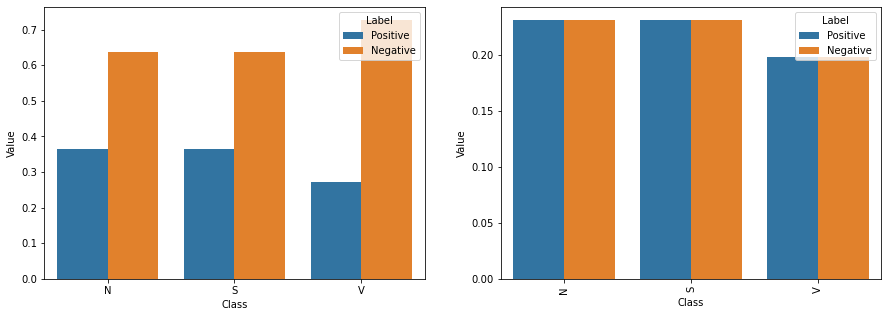

In [ ]:
import seaborn as sns

def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = keras.layers.Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = keras.layers.BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = keras.layers.Activation('relu')(norm1)  
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = keras.layers.Activation('relu')(norm1)    
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

#N= number of blocks in resnet, ch = different channels, win_len = common lenght for ecg signals, classes=..
def resnet(input_shape, N=6, custom_loss = None): 
    ecg_input = keras.layers.Input(shape=input_shape, name='ecg_signal') 
    ResNet = keras.layers.Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = keras.layers.BatchNormalization()(ResNet)
    ResNet = keras.layers.Activation('relu')(ResNet)
    ResNet = keras.layers.MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = keras.layers.GlobalMaxPooling1D(name='gmp_layer')(ResNet)

    # Sigmoid activation function on the last layer to retrieve all the combination, instead of softmax
    ResNet = keras.layers.Dense(3, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = keras.Model(inputs=[ecg_input],outputs=ResNet)
    return model

nn= resnet(x_train.shape[1:])

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=20,
    mode="auto",
)

batch_size = 32
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=int(len(x_train)/batch_size),
    decay_rate=0.85,
    staircase=True)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)

lr_metric = get_lr_metric(opt)
nn.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['Precision', 'Recall', lr_metric],
    
)


history = nn.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback]

).history


  3%|██▍                                                                       | 1554/48379 [00:00<00:03, 15427.39it/s]

100%|█████████████████████████████████████████████████████████████████████████| 48379/48379 [00:03<00:00, 15637.77it/s]


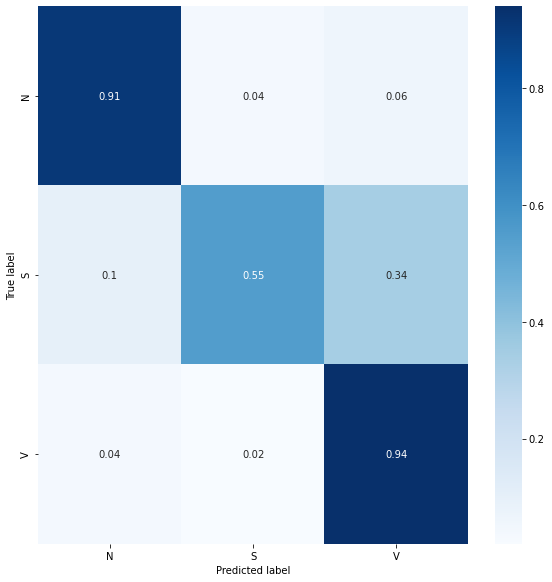

In [ ]:
import seaborn as sns 
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  #y_true = np.argmax(y_true,axis=1) already 1dimensional
  #y_pred = np.argmax(y_pred,axis=1)
  
  con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  return con_mat


print("Making predictions ...",end="\r")
y_pred= nn.predict(x_test)

y_pred=np.argmax(y_pred,axis=1)
y_val_classes=np.argmax(y_test, axis=1)

conf = plot_confusion_matrix(y_val_classes, y_pred,1)

In [ ]:
classes = ["N","S","V"]

results = {}

for i,c in enumerate(classes):
    
    results[c] = {}
    
    others = [0,1,2]
    others.remove(i)
    
    results[c]["tp"] = conf[i,i]
    results[c]["fn"] = 0
    results[c]["fp"] = 0
    
    for l in others:
        results[c]["fn"] += conf[i,l]
        results[c]["fp"] += conf[l,i]


recall_n = (results["N"]["tp"])/(results["N"]["tp"]+results["N"]["fn"])
precision_n = (results["N"]["tp"])/(results["N"]["tp"]+results["N"]["fp"])
f1_n = (2*recall_n*precision_n)/(precision_n+recall_n)
print(f"recall for N: {recall_n}")
print(f"precision for N: {precision_n}")
print(f"F1-score for N: {f1_n}")

recall_s = (results["S"]["tp"])/(results["S"]["tp"]+results["S"]["fn"])
precision_s = (results["S"]["tp"])/(results["S"]["tp"]+results["S"]["fp"])
f1_s = (2*recall_s*precision_s)/(precision_s+recall_s)
print(f"recall for S: {recall_s}")
print(f"precision for S: {precision_s}")
print(f"F1-score for S: {f1_s}")


recall_v = (results["V"]["tp"])/(results["V"]["tp"]+results["V"]["fn"])
precision_v = (results["V"]["tp"])/(results["V"]["tp"]+results["V"]["fp"])
f1_v = (2*recall_v*precision_v)/(precision_v+recall_v)
print(f"recall for V: {recall_v}")
print(f"precision for V: {precision_v}")
print(f"F1-score for V: {f1_v}")

recall for N: 0.9051747555233611
precision for N: 0.9920363203334326
F1-score for N: 0.9466171109322475
recall for S: 0.553959786622897
precision for S: 0.44790975447909753
F1-score for S: 0.49532195927352785
recall for V: 0.9382785956964892
precision for V: 0.32766462329444335
F1-score for V: 0.4857100981972739


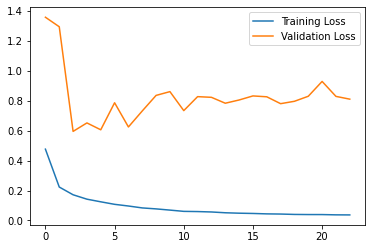

In [ ]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

<h2> Save and load model

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history) 
net_name = 'ResNetV0'
# save to csv: 
hist_csv_file = net_name +'_history.csv'
with open(os.path.join(cwd,hist_csv_file), mode='w') as f:
    hist_df.to_csv(f)
nn.save_weights(os.path.join(cwd,net_name +'_weights.h5'))
nn.save(os.path.join(cwd,net_name))

In [ ]:
nn= resnet(x_train.shape[1:])

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,
    mode="auto",
    restore_best_weights=True,

)


initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=int(len(x_train)/batch_size)*2,
    decay_rate=0.85,
    staircase=True)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)

lr_metric = get_lr_metric(opt)
nn.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['Precision', 'Recall', lr_metric],
    
)

nn.load_weights(os.path.join(cwd,net_name +'_weights.h5'))
